### Import packages and Dataframe

In [1]:
import importlib as imp
import graph_statistics
import graph_analysis

from collections import defaultdict

In [3]:
imp.reload(graph_statistics)
imp.reload(graph_analysis)

<module 'graph_analysis' from 'C:\\Users\\SIMONE\\Desktop\\Movielens - Big\\graph_analysis.py'>

In [4]:
from graph_analysis import *
from graph_statistics import *

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
df = pd.read_csv('csv/dataframe.csv',index_col=0,parse_dates=['date'],dtype={'userId': int,'movieId': str,'year': int})
df.sort_index(inplace=True)

In [6]:
G,users,movies = create_bipartite_graph(df,rating=True,rating_cutoff=0.0)

In [7]:
G_us_pear = user_projection_pearson(G,users)

In [8]:
Gu_pear_slc = slice_network(G_us_pear,T = 0.147)
Gu_pear_slc.remove_nodes_from(list(nx.isolates(Gu_pear_slc)))

#### Bipartite Degree Distribution

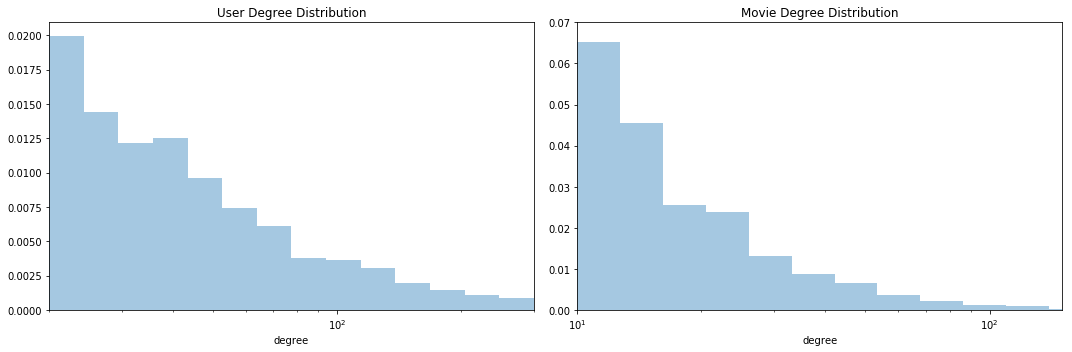

In [9]:
plt.subplots(1,2,figsize = (15,5))

dcu = dict(G.degree(users))
dcm = dict(G.degree(movies))

plt.subplot(121)
sns.distplot(list(dcu.values()),hist=True,norm_hist=True,kde=False,bins = np.logspace(np.log10(20),np.log10(300),15))
plt.xlabel('degree')
plt.title('User Degree Distribution')
plt.xscale('log')
plt.xlim((20,300))

plt.subplot(122)
sns.distplot(list(dcm.values()),hist=True,norm_hist=True,kde=False,bins = np.logspace(np.log10(10),np.log10(286),15))
plt.xlabel('degree')
plt.title('Movie Degree Distribution')
plt.xscale('log')
plt.ylim((0,0.07))
plt.xlim((10,150))

plt.tight_layout()

While most of the movies account for less than 50 views, the long-tail allows for
the formation of ’blockbusters’ that attained an incredible popularity. The ruling
principle is preferential attachment (also known as Rich-gets-Richer). The underlying
hypothesis is that people are more tempted to copy the others’ behavior. Users
may select titles inspired exclusively by personal taste, but once a highly-popular
movie starts emerging, its spread across information media can attract people who
were initially reluctant to watch it.

Similarly, few users enjoyed more than 100 titles, whereas most of them rated
less than 50 movies. Here we do not treat high degree as a sign of popularity, rather
it denotes that users decided to spend much of their spare time in consuming products.
This incredible activity is due to personal interest, and cannot be interpreted
in terms of social influence exerted directly by other users or mediated via the RS.

### Functions for plotting degree distribution

The analysis of the degree distribution of a network can unveil the dynamics that
are involved in its formation. If the network had links with random assignment,
the degree form should follow a Poisson distribution. Tough, in many real context,
the network manifests a power-law distribution:

$$p(k) = \gamma^{-k}$$

The term denotes the degree exponent of the distribution, usually ranging from
2 to 3. Most of power-law networks are called scale-frees; namely they cannot be
characterized by an internal scale. In statistical terms, the fluctuations around the
average degree hki are arbitrary large, and a node selected at random can manifest
either tiny or arbitrarily large degree. This property enables network to host hubs,
nodes with an enormous amount of links. Hubs are forbidden in a random network
because of the sharp decay in the high-degree region. Instead, hubs are naturally
expected to grow polynomially over time in a scale-free network.

According to the model proposed by Barabàsi-Albert, the scale-free property
arises from Preferential attachment and Rich-gets-richer phenomenon. The first
one states that nodes entering the network tend to link to the more connected
nodes, with the latter eventually becoming hubs. This principle leads to the richgets-
richer phenomenon: hubs are more likely to link to new nodes than the smaller
ones.

In [10]:
def binned_values(dc,nbins=15):

    """
    Return degree values for each bin and the respective frequency
    """

    # Get a list of degrees for each node
    degree_list = list(dc.values())

    # Get maximum and minimum degree
    kmin=min(degree_list)
    kmax=max(degree_list)

    start = max(np.log10(kmin),0)

    # Return numbers spaced evenly on a log scale
    # The sequence starts at base to the power of start and ends at base to the power of stop (included)
    logBins = np.logspace(start,np.log10(kmax),num=nbins,endpoint=True)

    # smallest integer value greater than or equal to x
    for x in range(len(logBins)):
        logBins[x] = mt.ceil(logBins[x])

    # a: is an array of values 
    # bins: it defines the bin edges, including the rightmost edge, allowing for non-uniform bin widths
    # density = True: the result is the value of the probability density function at the bin normalized

    logBinDensity = np.histogram(a=degree_list, bins=logBins,density=True)[0]  

    # Delete the rightmost bin in order to get the same length as logBinDensity
    logBins = np.delete(logBins, -1)

    return logBins,logBinDensity

In [11]:
def get_degree_dist(dc):

    """
    Return list of degree sores and their frequency
    """

    sequence = sorted([d for n, d in dc.items()],reverse = False)  

    Count = collections.Counter(sequence)

    seq, count = zip(*Count.items())

    # normalize counts
    freq = list(map(lambda x: x/sum(count),count))

    return seq,freq

In [12]:
bins,dens = binned_values(dcm,12)

In [13]:
from scipy.optimize import curve_fit
from scipy.special import factorial

In [14]:
def func(x, a, b):
    return a*np.power(x,-b)

In [15]:
# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

In [16]:
# fit with curve_fit
parameters, cov_matrix = curve_fit(func, bins, dens) 

In [17]:
par_pois,cov_matrix_pois = curve_fit(poisson,bins,dens)

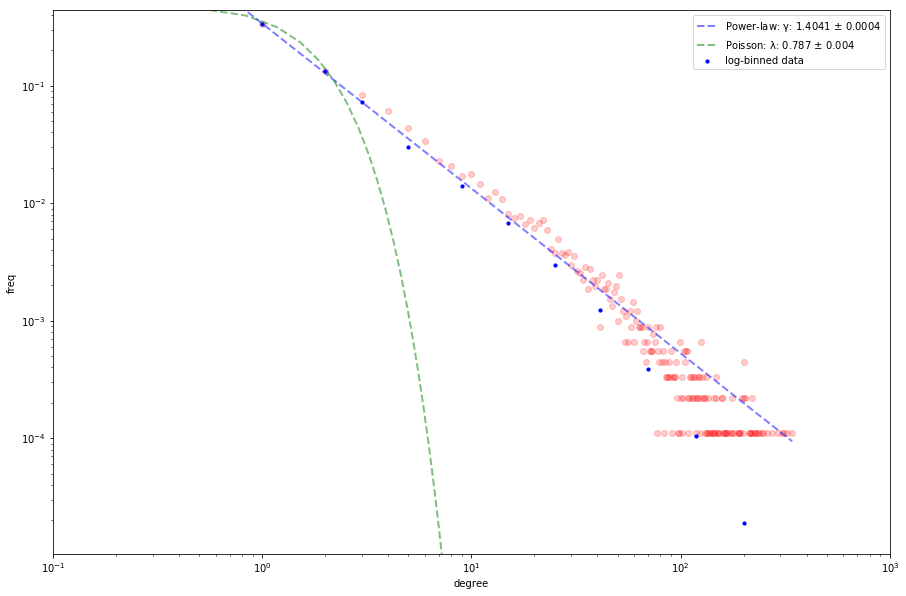

In [32]:
plt.figure(figsize=(15,10))

d,f = get_degree_dist(dcm)

plt.scatter(d,f,c = 'r',alpha = 0.2)
plt.scatter(bins,dens,s=10,c='b',label = 'log-binned data')

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(0.5, max(d), 1000)

plt.plot(x_plot, func(x_plot, *parameters), 'b--', lw=2,alpha = 0.5, label = 'Power-law: γ: {0} $\pm$ {1}'.format(round(parameters[1],4),round(cov_matrix[1,1],4)))
plt.plot(x_plot, poisson(x_plot, *par_pois), 'g--', lw=2,alpha = 0.5, label = 'Poisson: λ: {0} $\pm$ {1}'.format(round(par_pois[0],3),round(cov_matrix_pois[0][0],3)))

#plt.title('Degree Distribution')
plt.xlabel('degree')
plt.ylabel('freq')
plt.yscale('log')
plt.xscale('log')
plt.ylim((min(f)-10e-5,max(f)+10e-2))
plt.xlim((0.1,1000))
plt.legend()
plt.show()

### Fitting Procedure 

The first step in fitting a power law is to determine what portion of the data to fit. The Barabàsi-Albert book [1] provides the procedure to find the optimal value of D, used to perform the Kolmogorov - Smirnov test.

The procedure is implemented in the Open-source package power − law [2].

We scan the range 0 - 90 for different values of kcut. In practice, we follow the
procedure by keeping only nodes with degree inferior to kcut. According to Figure
5.4, the minimal value of D is globally achieved for Ksat = 32, by which less than
10% of the data points are included. The pair $(\gamma = 1.52,K_{sat} = 7)$, with respective
D = 0.082, offers the best trade-off between nodes coverage and minimal KS
distance. As mentioned earlier, it is not necessary to fix a kcut as it raises the value
of D.

In [33]:
data = list(dcm.values())

In [34]:
len_val = defaultdict(list)
D_val = defaultdict(list)

for e,m in enumerate(range(200,450,50)):
    for i in range(10,100):
        fit = powerlaw.Fit(data,xmin = i,xmax = m)
        D_val[e].append(fit.D)
        len_val[e].append(len(list(filter(lambda x: x>=i and x <=m,data)))/len(data))

C:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:697: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
C:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


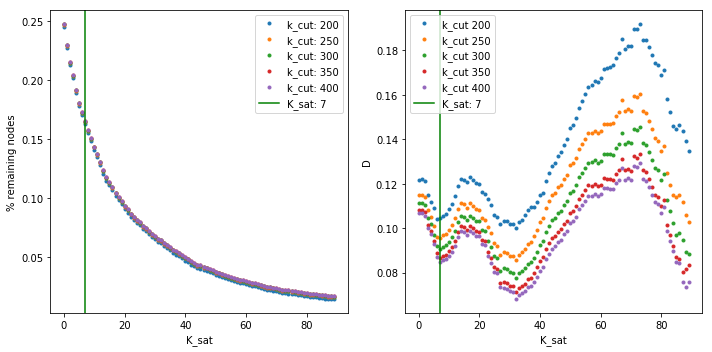

In [42]:
plt.subplots(1,2,figsize = (10,5))

plt.subplot(121)

for i in range(len(len_val)):
    plt.plot(len_val[i],'.',label = 'k_cut: {}'.format(200+50*i))
plt.xlabel('K_sat')
plt.ylabel('% remaining nodes')
plt.axvline(7,c = 'g',label = 'K_sat: {}'.format(7))
plt.legend()

plt.subplot(122)

for i in range(len(D_val)):
    plt.plot(D_val[i],'.',label = 'k_cut {}'.format(200+50*i))
plt.xlabel('K_sat')
plt.ylabel('D')
plt.axvline(7,c = 'g',label = 'K_sat: {}'.format(7))
#plt.axhline(0.085)
plt.legend()
plt.tight_layout()
plt.show()

The minimal value of D is achieved for a $K_{cut}$ above 80, for which less than 10% of the data points are examined. Even though a statistical test were to show significance, the result would be essentialy unreliable. Therefore, the first local minima around 15 will be kept as a $K_{cut}$ that best offers a trade-off between degree coverage of low KS distance. 

A $k_{sat}$ is not required as does not contribute to decrease the D value.

The figure below illustrates the difference between theoretical fit for $K_{cut} = 15$ and log-bins fit in bilogarithmic scale:

### Goodness-of-fit test

In [35]:
fit = powerlaw.Fit(data,xmin = 7,xmax = 400)

C:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [36]:
fit.D

0.10893842652189833

These results do not mean that the power law itself is a bad model for the studied distribution as all p-values are unsignificant under $0.05$. A goodness-of-fit test is required, which generates a p-value that quantifies the plausibility of the power law hypothesis.

In [37]:
M = 10000

In [30]:
dataf = list(filter(lambda x: x>=7 and x<=400,data))

In [34]:
D_val = []

for i in range(M):
    
    # Take the power law fit and generate a degree sequence of size N - number of users 
    simulated_data = fit.power_law.generate_random(len(dataf))
    
    # fit the data again with a power law
    fit2 = powerlaw.Fit(simulated_data,xmin=7,xmax=400)
    D = fit2.power_law.D
    
    # Compute kolmogorov - Smirnov distance with the simulated data
    D_val.append(D)
    
D_val = np.array(D_val)

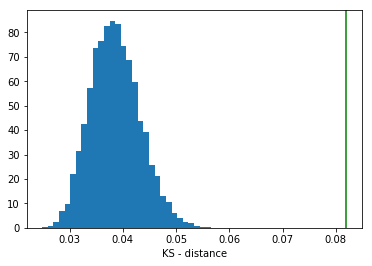

In [36]:
plt.hist(D_val,normed=True,bins=30)
plt.axvline(0.082, color = 'g',label = 'KS - dist original data')

#plt.legend()
plt.xlabel('KS - distance')
plt.show()

The green line falls visibly over the distribution obtained
by simulated data, attesting that the p-value is higher than the threshold 0.05. This
finding does not necessarily mean that the distribution does not follow a power-law
form, since the KS test is particularly sensitive to single outliers. If almost all data
points follow a perfect power law, but a single point for some reason deviates from
the curve, we will loose the fit’s statistical significance. In real systems there are
numerous reasons for such local deviations that have little impact on the system’s
overall behavior.

[1] Albert-László Barabási, Márton Pósfai (2016) Network Science, Cambridge
University Press.

[2] A. Clauset, C.R. Shalizi, and M.E.J. Newman (2009) Power-law distributions
in empirical data, SIAM Review S1: 661-703.